<a href="https://colab.research.google.com/drive/1cLnkAA0rsl4LjG0CDyzTuob_IFsQQO0A#scrollTo=ZlGBcFs4VtNf" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"  height="30" alt="Open In Colab"/></a>

## We have done all EDA and data preperation `parking_stream.csv` in [Model_1 notebook](https://colab.research.google.com/drive/1Dw7bq96qph9tsTQDs2uVDdf8uZxWTdIz#scrollTo=CZpoY1FWVDYV)

In [1]:
!pip install pathway bokeh panel --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import pathway as pw
import pandas as pd
import numpy as np
import datetime
import bokeh.plotting
import panel as pn

###  Define Schema

In [2]:
class ParkingSchema(pw.Schema):
    Timestamp: str
    SystemCodeNumber: str
    Occupancy: int
    Capacity: int
    QueueLength: int
    Traffic: str
    IsSpecialDay: int
    Vehicle: str
    nearest_system: str


## Load CSV as Streaming Data

In [3]:
data = pw.demo.replay_csv(
    "parking_stream.csv",
    schema=ParkingSchema,
    input_rate=1500
)


##  Parse Timestamp

In [4]:
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00"),
     Occ_rate = data.Occupancy / data.Capacity
)

In [18]:
import datetime

windowed = data_with_time.windowby(
    pw.this.t,
    instance = pw.this.SystemCodeNumber + "_" + pw.this.day,
    window = pw.temporal.tumbling(datetime.timedelta(days=1)),
    behavior = pw.temporal.exactly_once_behavior()
).reduce(
    t = pw.this._pw_window_end,

    # Retain grouping keys for later joins
    SystemCodeNumber = pw.reducers.argmax(pw.this.t, pw.this.SystemCodeNumber),
    day = pw.reducers.argmax(pw.this.t, pw.this.day),

    # Demand rate calculation
    earliest_occ = pw.reducers.earliest(pw.this.Occupancy),
    t_start = pw.reducers.earliest(pw.this.t),
    latest_occ = pw.reducers.argmax(pw.this.t, pw.this.Occupancy),       # ✅ deletion-safe latest


    # Demand rate-related components
    occ_max = pw.reducers.max(pw.this.Occupancy),
    occ_min = pw.reducers.min(pw.this.Occupancy),
    t_max = pw.reducers.max(pw.this.t),
    t_min = pw.reducers.min(pw.this.t),

    # Other lot-specific features
    cap = pw.reducers.max(pw.this.Capacity),
    queue = pw.reducers.argmax(pw.this.t, pw.this.QueueLength),
    traffic = pw.reducers.argmax(pw.this.t, pw.this.Traffic),
    special = pw.reducers.argmax(pw.this.t, pw.this.IsSpecialDay),
    vehicle = pw.reducers.argmax(pw.this.t, pw.this.Vehicle),
    occ_rate = pw.reducers.argmax(pw.this.t, pw.this.Occ_rate)           # ✅ also simulated latest
 #   occ_rate = pw.this.Occ_rate
)


/tmp/ipython-input-18-397797788.py:8: UserWarning: earliest reducer uses processing time to choose elements while windowby uses data time to assign entries to windows. Maybe it is not the behavior you want. To choose elements according to their data time, you may use min reducer.
  ).reduce(


In [7]:
  #  For vehicle_weight:
vehicle_weight = pw.if_else(
    pw.this.vehicle == "bike", 0.2,
    pw.if_else(
        pw.this.vehicle == "car", 1.0,
        pw.if_else(
            pw.this.vehicle == "truck", 1.5,
               pw.if_else(
            pw.this.vehicle == "cycle", 0.2,
             1 # default
          )
        )
    )
)

# or traffic weight
traffic_norm = pw.if_else(
    pw.this.traffic == "low", 1/3,
    pw.if_else(
        pw.this.traffic == "medium", 2/3,
        pw.if_else(
            pw.this.traffic == "high", 1.0,
            0.5  # fallback if unknown
        )
    )
)

# time diff in hours
time_diff = pw.this.t_max - pw.this.t_min
time_diff_hrs = time_diff / datetime.timedelta(hours=1)



##  **Model 2 — Context-Aware Demand Function**

###  **Goal**:
Construct a smart **demand estimation formula** based on real-time parking and contextual features to dynamically drive the pricing.

---

###  **Demand Function:**

The model computes a weighted **raw demand score** as follows:  

---



### ⚖️ **Assigned Weights:**
| Feature         | Weight | Description                                              |
|------------------|--------|----------------------------------------------------------|
| `occ_rate`       | 0.4    | Higher occupancy = more demand                           |
| `volatility`     | 1.0    | Fluctuation in demand adds urgency                       |
| `demand_rate`    | 0.8    | Speed of filling lots (rate of change)                  |
| `queue_length`   | 0.1    | Longer queue = higher urgency                           |
| `special_day`    | 0.5    | Special events increase demand                          |
| `vehicle_type`   | 0.4    | Heavier vehicles typically tolerate higher prices       |
| `traffic_level`  | -0.2   | More traffic → less desire to park                      |

---

###  Output:
- A new column `demand_raw` is computed for each lot & time window
- It will later be normalized into `norm_demand ∈ [0, 1]` to safely scale price
- This prepares the input for our final **price computation function**

---

> This demand function powers **Model 2**, which is more realistic than Model 1.



In [17]:
# Define weights for each demand-contributing feature
a = 0.4   # weight for occupancy rate (how full the lot is)
b = 1/15   # weight for queue length (how long the waiting line is)
c = 0.2   # penalty for traffic congestion (higher traffic lowers demand)
d = 0.5   # boost for special days (e.g., events, holidays)
e = 0.4   # weight for vehicle type (car > bike)
f = 0.8   # sensitivity to how fast the lot is filling (demand rate)
g = 1.0   # weight for volatility (occupancy fluctuation within window)

# Compute dynamic features from window
demand_rate = (pw.this.latest_occ - pw.this.earliest_occ) / time_diff_hrs  # occupancy rate change per min
volatility = (pw.this.occ_max - pw.this.occ_min) / pw.this.cap  # normalized volatility
#queue_norm = pw.this.queue / 15  # normalize queue length to [0, 1] scale

# Compute the raw demand signal from all influencing features
Price_model2 = windowed.with_columns(
    demand_raw = (
          a * pw.this.occ_rate        # more full → more demand
        + b * pw.this.queue           # longer queue → more demand
        - c * traffic_norm            # traffic congestion reduces parking attractiveness
        + d * pw.this.special         # special event? raise demand
        + e * vehicle_weight          # heavier vehicle → more price willingness
        + f * demand_rate             # faster filling → higher urgency
        + g * volatility              # rapid fluctuation → higher scarcity signal

    )
)


## 💰 Final Price Computation — Model 2

Once the raw demand is computed, we:
1. **Normalize it** into the range `[0, 1]` using:
 - `norm_demand = clip(demand_raw, 0, 2) / 2`
2. **Apply the price formula:**
`unclipped_price = base_price × (1 + λ × norm_demand)`

3. **Clip the final price** to avoid extreme values:
- Price < 8 → ₹8
- 8 ≤ Price ≤ 16 → actual computed value
- Price > 16 → cap at ₹16  
- Hard upper cap at ₹23 for safety

---

In [22]:
# keep base price as 10$ (given)
base_price = 10
lamda = 1.3  # tuning factor ( can change)

# Normalize it into the range `[0, 1]` using:
norm_demand = pw.if_else(
    pw.this.demand_raw < 0, 0,
    pw.if_else(pw.this.demand_raw > 2, 2, pw.this.demand_raw)
) / 2

unclipped_price = base_price * (1 + lamda * norm_demand)

price_model2 = Price_model2.with_columns(
    norm_demand = norm_demand,

    price = pw.if_else(
        unclipped_price > 23, 23, # when price is too high then keep it high
        pw.if_else(unclipped_price > 18, 18, # upper cap cap
          pw.if_else(unclipped_price < 8, 8 ,unclipped_price) # lower cap of price
            )
     )
)



In [13]:
df = pd.read_csv('parking_stream.csv')

In [16]:
list(df['SystemCodeNumber'].unique())

['BHMBCCMKT01',
 'BHMNCPHST01',
 'BHMMBMMBX01',
 'BHMNCPNST01',
 'Shopping',
 'BHMEURBRD01',
 'Broad Street',
 'Others-CCCPS8',
 'Others-CCCPS105a',
 'Others-CCCPS119a',
 'BHMBCCTHL01',
 'Others-CCCPS135a',
 'Others-CCCPS202',
 'Others-CCCPS98']

In [23]:
def plot_price_for_system(system_id: str):
    filtered = price_model2.filter(pw.this.SystemCodeNumber == system_id)

    def system_plotter(source):
        fig = bokeh.plotting.figure(
            height=400,
            width=800,
            title=f"Model 2 Price tracking for System {system_id}",
            x_axis_type="datetime"
        )
        fig.line("t", "price", source=source, line_width=2, color="green")
        fig.circle("t", "price", source=source, size=6, color="red")
        return fig

    return filtered.plot(system_plotter, sorting_col="t")

# Get unique system codes first
system_ids = list(df['SystemCodeNumber'].unique())  #

# Build plots for each system as tab
tabs = pn.Tabs(*[
    (f"System {sys}", plot_price_for_system(sys))
    for sys in system_ids
])

tabs.servable()



Tabs
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [1] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [2] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [3] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [4] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [5] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [6] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [7] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [8] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [9] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [10] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [11] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [12] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)
    [13] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

###  Model 2: Price Trends for System `BHMBCCMKT01`

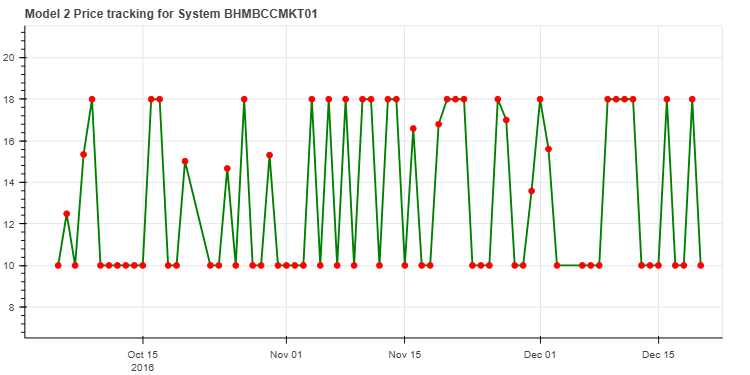

#### 🔍 Observations:
- Majority of prices hit upper (\$18-$23) or lower (\$10) bounds
- Very few prices lie in the mid-range (\$12-\$16)
- Frequent sharp transitions between high and low prices, indicating volatility
- Suggests that the demand model may be overly sensitive or under-normalized

####  General Insights (All Systems):
- Similar clipping trends observed across other systems
- Raw demand values frequently exceed bounds, causing saturation
- Price distribution appears skewed — limited price variation



In [24]:
pw.run()

Output()

In [ ]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

def price_plotter(source):
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Real-Time Parking Price",
        x_axis_type="datetime"
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "price", source=source, line_width=2, color="green")

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "price", source=source, size=4.2, color="red")
    return fig

#  create the visualization:
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = price_model2.plot(price_plotter, sorting_col="t")

#Serve the Panel app
pn.Column(viz).servable()


Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

# **Note: this is plotted as window of 35 mins `window = pw.temporal.tumbling(datetime.timedelta(minutes=1))` previously later we also plotted as daily price data for each window (which is current code) actually)**
###  Insights from the Plot of Model 2 (overall):
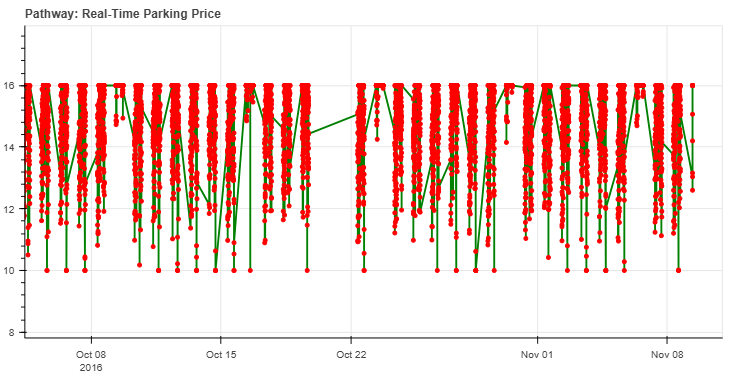

- Most prices hover near ₹16 (due to price clipping at the upper bound).
- Frequent dips indicate periods of lower demand (price near ₹10).
- The pricing is more responsive and **dense in variation** compared to Model 1.
- Some windows show steep recovery — suggesting **fast parking lot refills**.

---
##  Price Dynamics on Oct 29, 2016 — Model 2
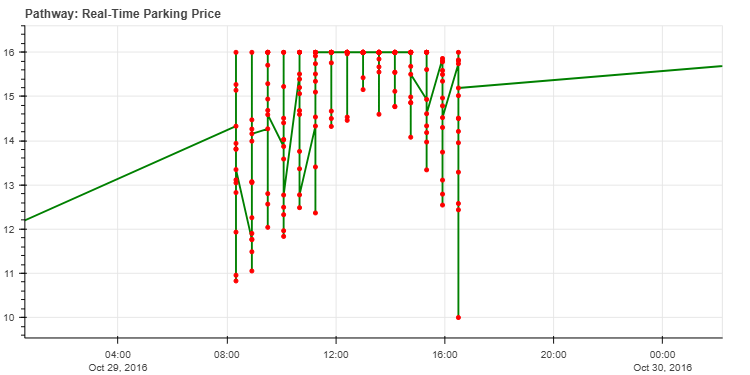

###  Quick Insights:
-  From 7 AM to 5 PM, prices remain **consistently high (₹14-₹16)** for some system due to:
  - High occupancy rate
  - Steady queue formation
  - Possibly special day or heavy vehicle mix

- ⬇ some dips around morning and evening indicate **temporary slowdowns in demand**.

-  Price is effectively clipped at ₹16, maintaining smoothness while still reacting to demand spikes.

---
>  This shows that Model 2 captures **complex behavior** using multiple contextual features, while still keeping price fluctuation bounded and interpretable.